In [1]:
from vif.utils.detection_utils import get_segmentation_masks
from vif.utils.image_utils import plot_segmentation_masks
from vif.utils.renderer.tex_renderer import TexRenderer
from PIL import Image
from google import genai
from google.genai import types as genTypes
import os

# APIs used
gclient = genai.Client(
    api_key=os.environ.get("GOOGLE_API_KEY"),
    http_options=genTypes.HttpOptions(api_version="v1alpha"),
)
# Models used
temperature = (0.3)
visual_model = "gemini-2.5-flash"

2025-11-06 12:35:18.745 | INFO     | vif.utils.caching:instantiate_cache:26 - seg_cache cache loaded


### With code rendering

In [ ]:
renderer = TexRenderer()

code = open("notebooks/protos/code/centered_circles.tex").read()

stcg = renderer.from_string_to_image(code)
stcg.save("tests/resources/seg/centered_circles.png")

In [ ]:
d = get_segmentation_masks(stcg,gclient,["circle","square","triangle"],visual_model)[0]

In [ ]:
import pickle

with open("tests/resources/seg/rgbp_stc.pickle","wb") as square_blurple_file:
    pickle.dump(d,square_blurple_file)

### With image path directly

In [2]:
stc = Image.open("tests/resources/seg/stc_rgb_rotc.png")

In [ ]:
stc_seg = get_segmentation_masks(
    stc,
    gclient,
    [
        "circle",
        "blue diamond",
    ],
    visual_model,
    enable_logprob=False
)[0]
print(stc_seg)

2025-11-06 12:35:20.715 | INFO     | vif.utils.detection_utils:get_segmentation_masks:216 - Getting masks for features : circle,blue diamond


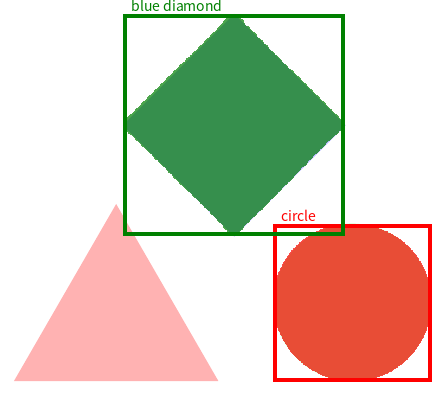

In [4]:
plot_segmentation_masks(stc,stc_seg)

In [ ]:
stc

In [ ]:
[(colnode_se.label,colnode_se.box_prob) for colnode_se in colnode_seg]

In [ ]:
import numpy as np
im_ar = [Image.fromarray(colnode_se.mask) for colnode_se in colnode_seg]
im_ar_mi = [Image.fromarray(np.flip(colnode_se.mask,0)) for colnode_se in colnode_seg]




In [ ]:
import pickle

with open("tests/resources/seg/centered_circles_neg.pickle", "wb") as pseg:
    pickle.dump(colnode_seg,pseg) 

In [ ]:
import pickle
with open("tests/resources/seg/dog_eyes_face.pickle", "rb") as pseg:
    s = pickle.load(pseg)

In [ ]:
for im,im_mi in zip(im_ar,im_ar_mi):
    display(im)
    display(im_mi)

In [ ]:
print(np.logical_and(s[1].mask, s[1].mask).sum())
print(s[1].mask.sum())


In [ ]:
from vif.utils.image_utils import apply_mask, crop_image_with_box


cropped = apply_mask(colnodes,s[2].mask)
boxed = Image.fromarray(crop_image_with_box(cropped,(s[2].x0,s[2].x1,s[2].y0,s[2].y1)))
boxed

### Using openrouter as a client

#### utils

In [ ]:
import json
import re
from loguru import logger
from openai import Client

from vif.baselines.models import CompletionUsage
from vif.models.detection import SegmentationMask
from vif.models.exceptions import InvalidMasksError, JsonFormatError, ParsingError
from vif.prompts.identification_prompts import SEGMENTATION_PROMPT

from vif.utils.detection_utils import (
    log_and_append_token_data,
    parse_segmentation_masks,
)
from vif.utils.image_utils import encode_image

from PIL import Image

SEGMENTATION_ATTEMPTS = 1


def get_segmentation_masks_routclient(
    image: Image.Image,
    client: Client,
    features,
    model,
) -> tuple[list[SegmentationMask], list]:
    encoded_image = encode_image(image=image)

    logger.info(f"Getting masks for features : {','.join(features)}")

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": SEGMENTATION_PROMPT.format(
                        labels=", ".join(['"' + feature + '"' for feature in features])
                    ),
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{encoded_image}"},
                },
            ],
        },
    ]

    token_data = []
    for attempt_nb in range(SEGMENTATION_ATTEMPTS):

        response = client.chat.completions.create(
            messages=messages,
            model=model,
            extra_body={
                "reasoning": {"enabled": False},
            },
            logprobs=True,
            temperature=0.3,
        )

        pattern = r"```(?:\w+)?\n([\s\S]+?)```"
        cnt_res = response.choices[0].message.content
        logger.info("LLM segmentation response: " + str(cnt_res))
        res_meta = response.usage

        ## handling none text error ##
        if cnt_res is None:
            error_msg = (
                f"Error while parsing response, response is None: {str(response)}"
            )
            log_and_append_token_data(token_data, res_meta, error_msg)
            if attempt_nb == SEGMENTATION_ATTEMPTS - 1:
                raise ParsingError(error_msg)
            continue

        id_match = re.search(pattern, cnt_res)

        ## handling parsing error ##
        if not id_match:
            error_msg = f"Error while parsing :{cnt_res}"

            log_and_append_token_data(token_data, res_meta, error_msg)
            if attempt_nb == SEGMENTATION_ATTEMPTS - 1:
                raise ParsingError(error_msg)
            continue

        ## handling json decoding error ##
        json_res = id_match.group(1)
        try:
            detected = json.loads(json_res)
        except json.JSONDecodeError as jde:
            error_msg = f"Error while decoding the json {json_res} : {jde}"
            log_and_append_token_data(token_data, res_meta, error_msg)
            if attempt_nb == SEGMENTATION_ATTEMPTS - 1:
                raise JsonFormatError(
                    f"Error while decoding the json {json_res} : {jde}"
                )
            continue

        ## handling segmentation mask parsing error ##
        try:
            seg_masks = parse_segmentation_masks(detected, image.height, image.width)
        except InvalidMasksError as ime:
            log_and_append_token_data(token_data, res_meta, str(ime))
            if attempt_nb == SEGMENTATION_ATTEMPTS - 1:
                raise ime
            attempt_nb += 1
            continue
        ## handling feature number detection error ##
        if len(seg_masks) < len(features):
            error_msg = f"The features {','.join(features)} were not detected."
            log_and_append_token_data(token_data, res_meta, error_msg)

            if attempt_nb == SEGMENTATION_ATTEMPTS - 1:
                raise InvalidMasksError(error_msg)
            continue
        log_and_append_token_data(token_data, res_meta, "Segmentation worked.")
        break

    # log_probs = get_mask_seg_logbprob(response)

    """ for seg_mask in seg_masks:
        seg_mask.box_prob = next(
            log_prob["box_prob"]
            for log_prob in log_probs
            if log_prob["label"] == seg_mask.label
        )
        seg_mask.seg_prob = next(
            log_prob["seg_prob"]
            for log_prob in log_probs
            if log_prob["label"] == seg_mask.label
        ) """

    return (seg_masks, token_data)


def log_and_append_token_data(token_data: list, res_meta: CompletionUsage, error_info):
    logger.warning(error_info)
    token_data.append(
        {
            **(res_meta.model_dump()),
            "error_info": error_info,
        }
    )

#### code

In [ ]:
import os
oclient = Client(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ.get("OPENROUTER_API_KEY"),
)
visual_model="google/gemini-2.5-flash"
stc = Image.open("tests/resources/seg/stc_rgb_rotc.png")

In [ ]:
stc_seg = get_segmentation_masks_routclient(
    stc,
    oclient,
    [
        "blue diamond",
        "circle",
    ],
    visual_model,
)[0]

In [ ]:
plot_segmentation_masks(stc,stc_seg)